In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
import plotly.graph_objects as go
import warnings

# Constructing a helix using the _Joint Face Normal Method_

This notebook will implement the following algorithm:

Given :
- the length $L$ of an object,
- the angles between the axis and the normal vectors of the joint faces $\theta/2$, where the angles are assumed to be the same but in opposite directions and the two face normals and the axis are co-planar. Note that the total angle between the planes defined by the joint faces are $\theta$, which is consistent with the reference,
- the twist angle $\tau$. This is the same angle described in the reference.

All relevant properties of the matrix will be computed. Then later, practical methods to find the right parameters for the welding application.

## Homogeneous coordinates and rigid transformations

In **homogeneous coordinates** in 3D, a space is described by a vector $(x, y, z, w)$. The corresponding cartesian coordinates are $(x/w, y/w, z/w)$. The point $(x, y, z, 0)$ signifies the point 'at infinity, so meaning a direction.

**Rigid body transormations** are transormations, where all distances are preserved. They include rotations and translations, which is all that is important here. The transformation matrix is of the form:

$$
M = \begin{pmatrix} r_{11}&r_{12}&r_{13}&t_x\\ r_{21}&r_{22}&r_{23}&t_y \\ r_{31}&r_{32}&r_{33}&t_z \\ 0 & 0& 0& 1\end{pmatrix}
$$

Where the matrix $R \in SO(3)$ is a rotation matrix and $\vec t$ the translation vector.

## The algorithm

To construct the helix, we will assume that the first point B lies at the origin. 
The first segment goes in the x direction, so C is at $(L,0,0,1)$.
Further, the joint faces of the first segment are normal to the $xy$-plane, meaning
$$N_B = (-\cos(\theta/2), \sin(\theta/2), 0, 1)\quad N_C = (\cos(\theta/2), \sin(\theta/2), 0, 1)$$
which are the normal vectors to the joint faces.

Note that this means that the axis of the helix is not the $z$-axis, and it is in fact not even parallel to it unless the twist angle $\tau$ is 0.

To determine the third point A we do the following:

1. translate C to the origin ($\vec t = (-L, 0, 0), R = \mathbf 1$)
2. rotate by $-\theta/2$ along the $z$-axis. Now $\vec N_B$ is aligned with the $x$-axis.
3. rotate by $\tau$ around the $x$-axis.
4. rotate by $-\theta/2$ around the $z$-axis again. Now the point D would lie where C was before, and B has moved to A.

Doing this transformation to B will give you A, and doing the inverse to C will give you D.

In [2]:
## Defining parameters

L = 60 ## mm
theta = 15 ## degrees
tau = 10 ## degrees


In [3]:
B = np.array([0,0,0,1])
C = np.array([L,0,0,1])

M, inverse_M = transformation_matrix(L, theta, tau)


In [4]:
A = np.array(M@B)
D = inverse_M@C

A

array([-57.97107948,  15.41118142,   1.35993813,   1.        ])

In [5]:
Bcart = homogeneous_to_cartesian(B)
x, y, z = Bcart.T

points = generate_points_on_helix(45, M)
axis_origin, axis_direction = find_helix_axis(M)
# axis_direction = find_axis_ev(M)
points_straight = transform_helix_to_z_axis(points.copy(), axis_origin, axis_direction)

In [6]:
x, y, z = points.T


fig = go.Figure()

rotated = make_second_helix(points_straight)
x,y,z = rotated.T
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


x, y, z = points_straight.T
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


#x, y, z = make_line(axis_origin + axis_direction * 500, axis_direction, length=1000).T
#fig.add_trace(go.Scatter3d(x=x, y=y, z=z, ))


#fig.update_layout(scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=None, autorange=True),
        yaxis=dict(range=None, autorange=True),
        zaxis=dict(range=None, autorange=True)
    )
)
fig.update_layout(
    scene=dict(
        aspectmode='data'   # ensures equal scaling for x, y, z
    )
)

fig.update_layout(
    template="plotly_white",          # clean background
    scene=dict(
        aspectmode="data",            # equal axes
        xaxis=dict(showbackground=False, showgrid=True, zeroline=False),
        yaxis=dict(showbackground=False, showgrid=True, zeroline=False),
        zaxis=dict(showbackground=False, showgrid=True, zeroline=False),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    font=dict(size=14, family="Arial"),
)

fig.update_layout(
    dragmode="turntable",        # intuitive rotation
    scene_camera=dict(eye=dict(x=4, y=1.8, z=1.2)),  # pleasant starting view
)

fig.update_traces(marker=dict(size=3, color='blue'))
fig.update_layout(showlegend=False, title_text="Helical path straightened along its axis")


fig.show()  # fully interactive in browser/notebook
fig.write_html("plot.html")  # shareable file

## Identifying the axis of the helix

In [7]:
BC = points[1] - points[0]
CD = points[2] - points[1]

angle_BCD = angle(BC, CD)
angle_BCD, point_line_distance(points_straight[2], [0,0,0], [0,0,1])

(14.942594097841914, 159.19514074432928)

In [8]:
## How many for desired length?

length = 1005 # mm

find_number_of_segments_for_length(points_straight, length)

(1005, 33.40647004908119, 30, 1002.1941014724358)

In [9]:
full_helix_calculation(60, 15, 12, segments = 30)

(array([[ -23.36627808, -138.23840821,    0.        ],
        [ -67.5026411 , -122.87894002,   37.63068157],
        [-104.13888399,  -93.86657177,   75.26136314],
        [-129.20440716,  -54.42482545,  112.89204472],
        [-139.91421684,   -8.93601605,  150.52272629],
        [-135.07836166,   37.54566109,  188.15340786],
        [-115.23414646,   79.8556945 ,  225.78408943],
        [ -82.58643309,  113.29307801,  263.41477101],
        [ -40.76266142,  134.14263263,  301.04545258],
        [   5.59019018,  140.08779472,  338.67613415],
        [  51.3219239 ,  130.46800597,  376.30681572],
        [  91.35135341,  106.35210711,  413.93749729],
        [ 121.23086709,   70.41958053,  451.56817887],
        [ 137.6405957 ,   26.66283691,  489.19886044],
        [ 138.75727819,  -20.05637567,  526.82954201],
        [ 124.4568416 ,  -64.54715357,  564.46022358],
        [  96.32818662, -101.86619124,  602.09090516],
        [  57.49664712, -127.86702478,  639.72158673],
        [ 

In [10]:
def plot_points(points, saveto = None):
    fig = go.Figure()

    x,y,z = points.T
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,))

    fig.update_layout(
    scene=dict(
        aspectmode='data'   # ensures equal scaling for x, y, z
    )
    )    

    fig.update_layout(
    dragmode="turntable",        # intuitive rotation
    scene_camera=dict(eye=dict(x=4, y=1.8, z=1.2)),  # pleasant starting view
    )

    fig.show()

    if saveto is not None:
        fig.write_html(saveto)




def plot_helix(L, theta, tau, segments = 45, saveto = None, double_helix = True):

    data = full_helix_calculation(L, theta, tau, segments = segments)
    points = data[0]

    if double_helix:
        points2 = points.copy()
        points2 = make_second_helix(points2)
        points = np.vstack((points, points2[::-1]))

    plot_points(points, saveto)


plot_helix(60, 15, 20, segments = 12, saveto = "helix.html", double_helix = True)


In [11]:
def vis_tangent_vectors(segments, L, theta, tau):
    radius, polar_angle, deltaz = find_helix_parameters(L, theta, tau)
    normal_vectors = []
    for n in range(segments + 1):
        x = - radius * polar_angle * np.sin(n * polar_angle)
        y = radius * polar_angle * np.cos(n * polar_angle)
        z = deltaz
        normal_vectors.append(unit(np.array([x,y,z])))
    return np.asarray(normal_vectors)

def xy_perp(v):
    ## find the vector orthogonal to v lying in the xy plane
    vx, vy, vz = v
    # Handle special case where v has no xy component
    if vx == 0 and vy == 0:
        # any xy vector is fine, choose (1, 0, 0)
        return np.array([1, 0, 0], dtype=float)
    w = np.array([-vy, vx, 0], dtype=float)
    return unit(w)

def vis_local_xy_plane(vectors):
    basis = []
    for vector in vectors:
        vector = unit(vector.copy())
        u1 = xy_perp(vector)
        u2 = unit(np.cross(vector, u1))
        basis.append([u1, u2])
    return np.array(basis)




def vis_circle(angle, point, basis, pipe_diameter):
    r = pipe_diameter / 2
    return point + r * (np.cos(angle)*basis[0] + np.sin(angle)*basis[1])

def vis_whole_circle(point, basis, pipe_diameter, sides = 10):
    points = []
    angles = np.linspace(0,2*np.pi, sides)
    for angle in angles:
        points.append(vis_circle(angle, point, basis, pipe_diameter))
    return np.asarray(points)

In [12]:
def connect_lines_mesh3d(line1, line2, color='lightblue', opacity=0.6, name='surface'):
    """
    Create a Mesh3d surface filling the area between two 3D lines.
    
    Parameters
    ----------
    line1, line2 : (N,3) array_like
        Arrays of 3D points with the same length.
    color : str
        Color of the surface.
    opacity : float
        Opacity of the surface.
    name : str
        Trace name for Plotly legend.
    
    Returns
    -------
    go.Mesh3d
        Plotly Mesh3d trace connecting the two lines.
    """
    line1 = np.asarray(line1)
    line2 = np.asarray(line2)
    assert line1.shape == line2.shape, "Both lines must have same number of points"

    n = len(line1)
    x = np.concatenate([line1[:,0], line2[:,0]])
    y = np.concatenate([line1[:,1], line2[:,1]])
    z = np.concatenate([line1[:,2], line2[:,2]])

    # Triangles between the two lines
    triangles = []
    for i in range(n - 1):
        triangles += [
            (i, i + 1, n + i),
            (i + 1, n + i + 1, n + i)
        ]
    i, j, k = np.array(triangles).T

    return go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        color=color, opacity=opacity,
        name=name
    )


In [13]:
# Example lines
t = np.linspace(0, 2*np.pi, 100)
line1 = np.column_stack((np.cos(t), np.sin(t), 0.2*t))
line2 = np.column_stack((1.05*np.cos(t), 1.05*np.sin(t), 0.2*t + 0.2))

# Make figure
fig = go.Figure()

fig.add_trace(connect_lines_mesh3d(line1, line2, color='lightblue', opacity=0.6))
fig.add_trace(go.Scatter3d(x=line1[:,0], y=line1[:,1], z=line1[:,2],
                           mode='lines', line=dict(color='blue', width=5), name='Line 1'))
fig.add_trace(go.Scatter3d(x=line2[:,0], y=line2[:,1], z=line2[:,2],
                           mode='lines', line=dict(color='red', width=5), name='Line 2'))

fig.update_layout(scene=dict(aspectmode='data'))
fig.show()


In [14]:
def plot_helix(L, theta, tau, segments, pipe_diameter, sides = 10, double_helix = True):

    fig = go.Figure()
    origin = np.zeros(3)
    segments = 25

    points_straight = generate_straight_matrix(L, theta, tau, segments)
    vectors = vis_tangent_vectors(segments, L, theta, tau)

    vectors = np.gradient(points_straight, axis=0)
    basis = vis_local_xy_plane(vectors)

    circles = []
    for i in range(len(basis)):
        circles.append(vis_whole_circle(points_straight[i], basis[i], pipe_diameter, sides = sides))
        
    circles = np.asarray(circles)
    lines = np.transpose(circles, axes=[1,0,2])

    for i in range(len(lines) -1):
        fig.add_trace(connect_lines_mesh3d(lines[i], lines[i+1], color='blue', opacity = .6))


    for circle in lines:
        x,y,z = circle.T
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode = 'lines', line = dict(color = 'blue')))
        i = i+1


    if double_helix:
            second_points = make_second_helix(points_straight)
            vectors = vis_tangent_vectors(segments, L, theta, tau)


            vectors = np.gradient(second_points, axis=0)
            basis = vis_local_xy_plane(vectors)

            circles = []
            for i in range(len(basis)):
                circles.append(vis_whole_circle(second_points[i], basis[i], pipe_diameter, sides = sides))
                
            circles = np.asarray(circles)
            lines = np.transpose(circles, axes=[1,0,2])

            for i in range(len(lines) -1):
                fig.add_trace(connect_lines_mesh3d(lines[i], lines[i+1], color='red', opacity = .6))



            for circle in lines:
                x,y,z = circle.T
                fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode = 'lines', line = dict(color = 'red')))
                i = i+1



    fig.update_layout(
    scene=dict(
        aspectmode='data'   # ensures equal scaling for x, y, z
    )
    )    

    fig.update_layout(
    dragmode="turntable",        # intuitive rotation
    scene_camera=dict(eye=dict(x=0, y=1.8, z=1.2)),  # pleasant starting view
    )

    fig.show()

plot_helix(21,90,25,25,10, 10,True)

In [15]:
### Is helix allowed?

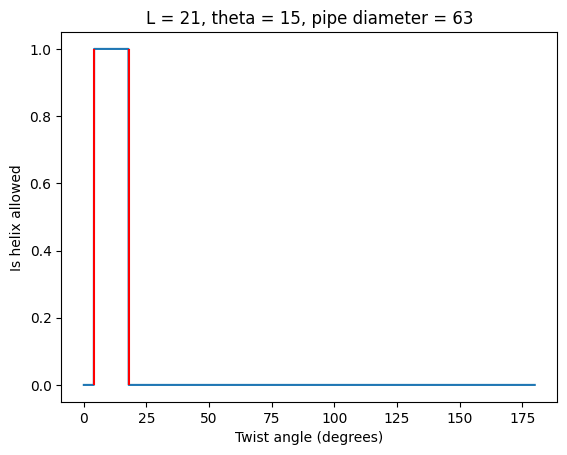

(4.0, 18.0)

In [16]:




def is_helix_allowed(L, theta, tau, pipe_diameter, eps_wide = 3, eps_loose = 3):
    return is_helix_loose_enough(L, theta, tau, pipe_diameter, eps = eps_loose) * is_helix_wide_enough(L, theta, tau, pipe_diameter, eps = eps_wide)

tautau = np.arange(0.1,180,0.1)
L = 21
theta = 15
helix_possible = np.zeros(len(tautau), dtype = int)
pipe_diameter = 63
for i, tau in enumerate(tautau):
    helix_possible[i] = is_helix_allowed(L, theta, tau, pipe_diameter)


def find_allowed_twist_range(L, theta, pipe_diameter, accuracy = 0.1):
    def toggle(truth):
        if truth:
            return False
        else:
            return True

    taumin = 0
    taumax = 0
    eps = 1
    direction = 1
    want = True

    while eps > accuracy:
        if taumin > 180:
            taumin = None
            taumax = None
            return taumin, taumax
        if taumin < 0:
            taumin = -1
            break
        taumin = taumin + direction * eps
        possible = is_helix_allowed(L, theta, taumin, pipe_diameter)
        if possible == want:
            eps /= 2
            direction *= -1
            want = toggle(want)
            if want:
                taumax = taumin

    direction = 1
    eps = 0.5
    want = False

    while eps > accuracy:
        taumax = taumax + direction * eps
        possible = is_helix_allowed(L, theta, taumax, pipe_diameter)
        if possible == want:
            eps /= 2
            direction *= -1
            toggle(want)

    return taumin, taumax

taumin, taumax = find_allowed_twist_range(L, theta, pipe_diameter)




plt.plot(tautau, helix_possible)
plt.xlabel("Twist angle (degrees)")
plt.ylabel("Is helix allowed")
plt.title(f"L = {L}, theta = {theta}, pipe diameter = {pipe_diameter}")
plt.vlines([taumin, taumax], 0,1, colors = 'red')
plt.show()

taumin, taumax